# Create/Load Train-Valid-Test Splits

In [ ]:
import pandas as pd
import numpy as np

metadata = pd.read_csv('bucket/metadata.csv')
metadata.head()

,type,patient,replicate,count_matrix,histology_image,spot_coordinates,tumor_annotation
0,HER2_luminal,BC23287,C1,BC23287_C1_stdata.tsv.gz,HE_BT23287_C1.jpg,spots_BT23287_C1.csv.gz,BC23287_C1_Coords.tsv.gz
1,HER2_luminal,BC23287,C2,BC23287_C2_stdata.tsv.gz,HE_BT23287_C2.jpg,spots_BT23287_C2.csv.gz,BC23287_C2_Coords.tsv.gz
2,HER2_luminal,BC23287,D1,BC23287_D1_stdata.tsv.gz,HE_BT23287_D1.jpg,spots_BT23287_D1.csv.gz,BC23287_D1_Coords.tsv.gz
3,HER2_luminal,BC23450,D2,BC23450_D2_stdata.tsv.gz,HE_BT23450_D2.jpg,spots_BT23450_D2.csv.gz,BC23450_D2_Coords.tsv.gz
4,HER2_luminal,BC23450,E1,BC23450_E1_stdata.tsv.gz,HE_BT23450_E1.jpg,spots_BT23450_E1.csv.gz,BC23450_E1_Coords.tsv.gz


Text(0.5, 0, 'Count')

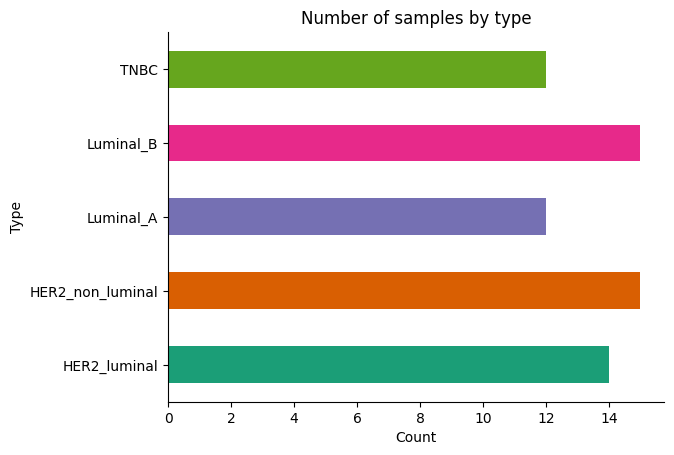

In [ ]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
metadata.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Number of samples by type')
plt.ylabel('Type')
plt.xlabel('Count')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(metadata_df):
    # Get unique patient IDs and cancer types
    patient_ids = metadata_df['patient'].unique()
    cancer_types = metadata_df['type'].unique()

    # Create a dictionary to store patient IDs for each cancer type
    cancer_patients = {cancer_type: metadata_df[metadata_df['type'] == cancer_type]['patient'].unique()
                       for cancer_type in cancer_types}

    # Randomly select one patient from each cancer type for the test set
    test_patients = [np.random.choice(patients, 1)[0] for patients in cancer_patients.values()]

    # Randomly select one patient from each cancer type for the validation set
    remaining_patients = {cancer_type: [p for p in patients if p not in test_patients]
                          for cancer_type, patients in cancer_patients.items()}
    valid_patients = [np.random.choice(patients, 1)[0] for patients in remaining_patients.values()]

    # Assign remaining patients to the train set
    train_patients = [p for p in patient_ids if p not in test_patients + valid_patients]

    # Split the data into train, validation, and test sets based on patient IDs
    train_df = metadata_df[metadata_df['patient'].isin(train_patients)]
    valid_df = metadata_df[metadata_df['patient'].isin(valid_patients)]
    test_df = metadata_df[metadata_df['patient'].isin(test_patients)]

    return train_df, valid_df, test_df

train_metadata, valid_metadata, test_metadata  = split_data(metadata)

In [ ]:
# print('Train metadata')
# print(79*'-')
# print(f'''
# Size: {len(train_metadata)}
# Distribution of cancer types: {train_metadata.value_counts('type')}
#       ''')
# print(79*'-')
# print('Valid metadata')
# print(79*'-')
# print(f'''
# Size: {len(valid_metadata)}
# Distribution of cancer types: {valid_metadata.value_counts('type')}
#       ''')
# print(79*'-')
# print('Test metadata')
# print(79*'-')
# print(f'''
# Size: {len(test_metadata)}
# Distribution of cancer types: {test_metadata.value_counts('type')}
#       ''')
# print(79*'-')

Train metadata
-------------------------------------------------------------------------------

Size: 38
Distribution of cancer types: type
HER2_non_luminal    9
Luminal_B           9
HER2_luminal        8
Luminal_A           6
TNBC                6
Name: count, dtype: int64
      
-------------------------------------------------------------------------------
Valid metadata
-------------------------------------------------------------------------------

Size: 15
Distribution of cancer types: type
HER2_luminal        3
HER2_non_luminal    3
Luminal_A           3
Luminal_B           3
TNBC                3
Name: count, dtype: int64
      
-------------------------------------------------------------------------------
Test metadata
-------------------------------------------------------------------------------

Size: 15
Distribution of cancer types: type
HER2_luminal        3
HER2_non_luminal    3
Luminal_A           3
Luminal_B           3
TNBC                3
Name: count, dtype: int64

In [ ]:
# train_metadata.to_csv('bucket/train_metadata.csv', index = True)
# valid_metadata.to_csv('bucket/valid_metadata.csv', index = True)
# test_metadata.to_csv('bucket/test_metadata.csv', index = True)

# Preprocessing data

In [ ]:
from typing_extensions import final
from gc import collect
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
import os



def create_mask(spot_indices, st_data_indices):
  '''returns 3 arguments - first is the common indices, and the other two are
  the boolean masks '''
  # Assuming spots_indices and st_data_indices are numpy arrays or lists
  common_indices = st_data_indices.intersection(spot_indices)
  return common_indices

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)


# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg') #  pooling='avg')

# Choose the layer from which you want to get the features
# Let's try using the last layer before the fully connected layers
model = Model(inputs=base_model.input, outputs=base_model.output)

def preprocess_image(img):
    return preprocess_input(img)

def preprocess_single_image(img):
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)


def extract_features(preprocessed_img, model):
    features = model.predict(preprocessed_img)
    # Flatten the features to fit your embedding size requirement
    # For example, we flatten it and could use PCA or another method to reduce dimensionality if needed

    return features

# Use train_data to train PCA for image embedding
data_path = 'bucket/spots/'
st_data_path = 'bucket/stdata'
image_data_path = 'bucket/images/'

def extract_model_data(metadata, run_name, image_feature_length = 2048, embedding_length = 32):
  try:
    for _, record in metadata.iterrows():
      spot_data = pd.read_csv(os.path.join(data_path, record['spot_coordinates']),index_col = 0)
      # match common indices
      spot_indices = spot_data.index
      st_data_indices = pd.read_csv(f'bucket/stdata/{record["count_matrix"]}', sep = '\t', usecols = [0], index_col = 0).index
      spot_mask  =  create_mask(spot_indices, st_data_indices)
      spot_data = spot_data.loc[spot_mask]
      # get image data
      image = cv2.imread(os.path.join(image_data_path, record['histology_image'].replace('.jpg','.tif')), cv2.IMREAD_UNCHANGED)
      print(f"Reading image for Patient: {record['patient']}, Section: {record['replicate']}")
      img_windows = []
      for _ , spot in spot_data.iterrows():
        start_x = round(spot['X']) - 112
        start_y = round(spot['Y']) - 112

        window = image[start_y:start_y + 224, start_x:start_x + 224]
        preprocessed_window = preprocess_image(window)
        img_windows.append(preprocessed_window)
      img_windows = np.array(img_windows)
      features = extract_features(img_windows, model)

      # get neighbor data
      adj_embedding = pd.read_csv(f"bucket/svd/svd_{record['patient']}_{record['replicate']}.csv",header=None).to_numpy()
      assert len(adj_embedding) == len(spot_data)


      # Create dataframes
      df_index = pd.MultiIndex.from_tuples(product([record['patient']], [record['replicate']], spot_data.index),
                                           names = ['Patient', 'Replicate', 'Index']) # create index
      column_names = [f'img_feature_{i}' for i in range(image_feature_length)]
      image_df = pd.DataFrame(index = df_index, columns = column_names)
      image_df[column_names] = features

      adj_column_names = [f'adj_feature_{i}' for i in range(embedding_length)]
      adj_df = pd.DataFrame(index=df_index, columns = adj_column_names)
      adj_df[adj_column_names] = adj_embedding

      # Saving
      image_loc = f"bucket/datasets/{run_name}/preprocessed_img" # index matching done
      adj_loc = f"bucket/datasets/{run_name}/aligned_svd_features" # index matching done
      if not os.path.exists(image_loc):
        os.makedirs(image_loc)
      if not os.path.exists(adj_loc):
        os.makedirs(adj_loc)

      # with open(f"{image_loc}/{record['patient']}_{record['replicate']}_img_features.npy", 'wb') as f:
      #   np.save(f, features)
      image_df.to_csv(f"{image_loc}/{record['patient']}_{record['replicate']}_img_features.csv")
      adj_df.to_csv(f"{adj_loc}/{record['patient']}_{record['replicate']}_adj_features.csv")
  except Exception as e:
    print(record['patient'], record['replicate'])
    raise(e)
  finally:
    print('Data Extraction complete.')



extract_model_data(train_metadata, run_name = 'simple_baseline')
extract_model_data(valid_metadata, run_name = 'simple_baseline')
extract_model_data(test_metadata, run_name = 'simple_baseline')


Reading image for Patient: BC23287, Section: C1
8/8 [==============================] - 8s 889ms/step
Reading image for Patient: BC23287, Section: C2
11/11 [==============================] - 10s 833ms/step
Reading image for Patient: BC23287, Section: D1
12/12 [==============================] - 10s 843ms/step
Reading image for Patient: BC23901, Section: C2
10/10 [==============================] - 8s 816ms/step
Reading image for Patient: BC23901, Section: D1
10/10 [==============================] - 8s 829ms/step
Reading image for Patient: BC23944, Section: D2
13/13 [==============================] - 12s 885ms/step
Reading image for Patient: BC23944, Section: E1
14/14 [==============================] - 12s 845ms/step
Reading image for Patient: BC23944, Section: E2
13/13 [==============================] - 11s 855ms/step
Reading image for Patient: BC23567, Section: D2
19/19 [==============================] - 17s 873ms/step
Reading image for Patient: BC23567, Section: E1
18/18 [==============

## KNN Image Preprocessing

In [ ]:
# Goal: Create kNN based image embedding
## Read adjacency matrix
import anndata
from tqdm import tqdm
patient = 'BC23209'
replicate = 'C1'

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)

metadata = train_metadata.copy()
image_loc = train_metadata
# start
def knn_image_processing(metadata, run_name):

  out_loc = f'bucket/datasets/{run_name}/knn_preprocessed_img'
  if not os.path.exists(out_loc):
    os.makedirs(out_loc)

  for _ , record in metadata.iterrows():
    patient = record['patient']
    replicate = record['replicate']
    print(f'Pooling neighbor images for Patient: {patient}, Replicate: {replicate}')
    # start
    image = pd.read_csv(f'bucket/datasets/{run_name}/preprocessed_img/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
    adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
    labels = image.loc[(patient, replicate)].index
    adata = adata[labels] # subset to required indices
    distances = adata.obsp['distances']
    # index matcher
    indices = adata.obs_names.get_indexer(labels)
    l2i_mapper = {label:index for label, index in  zip(labels, indices)}
    i2l_mapper = {index:label for label, index in  zip(labels, indices)}
    pooled_dataframe = image.copy()
    for i in tqdm(range(len(labels))):
      label = labels[i]
      index = adata.obs_names.get_loc(label)
      neighbor_indices = distances[index].nonzero()[1]
      neighbor_labels = pd.Index([i2l_mapper[i] for i in neighbor_indices])
      neighbor_images = image.loc[patient, replicate, neighbor_labels]
      pooled_dataframe.loc[patient, replicate, label] = neighbor_images.mean(axis = 0)
    pooled_dataframe.to_csv(f'{out_loc}/{patient}_{replicate}_img_features.csv')

knn_image_processing(train_metadata, 'knn_pooling')
knn_image_processing(valid_metadata, 'knn_pooling')
knn_image_processing(test_metadata,  'knn_pooling')


Pooling neighbor images for Patient: BC23287, Replicate: C1


100%|██████████| 256/256 [00:01<00:00, 178.74it/s]


Pooling neighbor images for Patient: BC23287, Replicate: C2


100%|██████████| 334/334 [00:01<00:00, 180.08it/s]


Pooling neighbor images for Patient: BC23287, Replicate: D1


100%|██████████| 357/357 [00:02<00:00, 173.03it/s]


Pooling neighbor images for Patient: BC23901, Replicate: C2


100%|██████████| 292/292 [00:01<00:00, 179.34it/s]


Pooling neighbor images for Patient: BC23901, Replicate: D1


100%|██████████| 297/297 [00:01<00:00, 177.88it/s]


Pooling neighbor images for Patient: BC23944, Replicate: D2


100%|██████████| 414/414 [00:02<00:00, 181.86it/s]


Pooling neighbor images for Patient: BC23944, Replicate: E1


100%|██████████| 423/423 [00:02<00:00, 185.33it/s]


Pooling neighbor images for Patient: BC23944, Replicate: E2


100%|██████████| 403/403 [00:02<00:00, 165.85it/s]


Pooling neighbor images for Patient: BC23567, Replicate: D2


100%|██████████| 587/587 [00:03<00:00, 153.63it/s]


Pooling neighbor images for Patient: BC23567, Replicate: E1


100%|██████████| 572/572 [00:02<00:00, 191.19it/s]


Pooling neighbor images for Patient: BC23567, Replicate: E2


100%|██████████| 570/570 [00:02<00:00, 220.19it/s]


Pooling neighbor images for Patient: BC23903, Replicate: C1


100%|██████████| 441/441 [00:02<00:00, 190.88it/s]


Pooling neighbor images for Patient: BC23903, Replicate: C2


100%|██████████| 468/468 [00:02<00:00, 203.62it/s]


Pooling neighbor images for Patient: BC23903, Replicate: D1


100%|██████████| 464/464 [00:03<00:00, 139.65it/s]


Pooling neighbor images for Patient: BC24044, Replicate: D2


100%|██████████| 614/614 [00:02<00:00, 209.21it/s]


Pooling neighbor images for Patient: BC24044, Replicate: E1


100%|██████████| 603/603 [00:02<00:00, 208.51it/s]


Pooling neighbor images for Patient: BC24044, Replicate: E2


100%|██████████| 511/511 [00:02<00:00, 192.12it/s]


Pooling neighbor images for Patient: BC23269, Replicate: C1


100%|██████████| 434/434 [00:02<00:00, 180.60it/s]


Pooling neighbor images for Patient: BC23269, Replicate: C2


100%|██████████| 435/435 [00:02<00:00, 204.63it/s]


Pooling neighbor images for Patient: BC23269, Replicate: D1


100%|██████████| 433/433 [00:01<00:00, 221.64it/s]


Pooling neighbor images for Patient: BC23272, Replicate: D2


100%|██████████| 565/565 [00:02<00:00, 228.17it/s]


Pooling neighbor images for Patient: BC23272, Replicate: E1


100%|██████████| 578/578 [00:02<00:00, 203.85it/s]


Pooling neighbor images for Patient: BC23272, Replicate: E2


100%|██████████| 548/548 [00:02<00:00, 241.51it/s]


Pooling neighbor images for Patient: BC23270, Replicate: D2


100%|██████████| 284/284 [00:01<00:00, 275.32it/s]


Pooling neighbor images for Patient: BC23270, Replicate: E1


100%|██████████| 283/283 [00:01<00:00, 239.39it/s]


Pooling neighbor images for Patient: BC23270, Replicate: E2


100%|██████████| 284/284 [00:01<00:00, 235.47it/s]


Pooling neighbor images for Patient: BC23508, Replicate: D2


100%|██████████| 478/478 [00:01<00:00, 263.10it/s]


Pooling neighbor images for Patient: BC23508, Replicate: E1


100%|██████████| 473/473 [00:01<00:00, 245.42it/s]


Pooling neighbor images for Patient: BC23508, Replicate: E2


100%|██████████| 504/504 [00:02<00:00, 247.07it/s]


Pooling neighbor images for Patient: BC23895, Replicate: C1


100%|██████████| 498/498 [00:02<00:00, 243.99it/s]


Pooling neighbor images for Patient: BC23895, Replicate: C2


100%|██████████| 454/454 [00:01<00:00, 244.35it/s]


Pooling neighbor images for Patient: BC23895, Replicate: D1


100%|██████████| 518/518 [00:02<00:00, 243.31it/s]


Pooling neighbor images for Patient: BC23288, Replicate: D2


100%|██████████| 464/464 [00:01<00:00, 239.54it/s]


Pooling neighbor images for Patient: BC23288, Replicate: E1


100%|██████████| 480/480 [00:01<00:00, 253.66it/s]


Pooling neighbor images for Patient: BC23288, Replicate: E2


100%|██████████| 478/478 [00:01<00:00, 252.15it/s]


Pooling neighbor images for Patient: BC23377, Replicate: C1


100%|██████████| 597/597 [00:02<00:00, 203.47it/s]


Pooling neighbor images for Patient: BC23377, Replicate: C2


100%|██████████| 687/687 [00:03<00:00, 224.56it/s]


Pooling neighbor images for Patient: BC23377, Replicate: D1


100%|██████████| 601/601 [00:02<00:00, 247.99it/s]


Pooling neighbor images for Patient: BC23450, Replicate: D2


100%|██████████| 316/316 [00:01<00:00, 275.29it/s]


Pooling neighbor images for Patient: BC23450, Replicate: E1


100%|██████████| 301/301 [00:01<00:00, 228.41it/s]


Pooling neighbor images for Patient: BC23450, Replicate: E2


100%|██████████| 318/318 [00:01<00:00, 214.75it/s]


Pooling neighbor images for Patient: BC23810, Replicate: D2


100%|██████████| 691/691 [00:02<00:00, 238.79it/s]


Pooling neighbor images for Patient: BC23810, Replicate: E1


100%|██████████| 695/695 [00:03<00:00, 224.75it/s]


Pooling neighbor images for Patient: BC23810, Replicate: E2


100%|██████████| 713/713 [00:03<00:00, 204.74it/s]


Pooling neighbor images for Patient: BC24223, Replicate: D2


100%|██████████| 368/368 [00:01<00:00, 209.41it/s]


Pooling neighbor images for Patient: BC24223, Replicate: E1


100%|██████████| 362/362 [00:01<00:00, 214.50it/s]


Pooling neighbor images for Patient: BC24223, Replicate: E2


100%|██████████| 363/363 [00:01<00:00, 230.32it/s]


Pooling neighbor images for Patient: BC23277, Replicate: D2


100%|██████████| 506/506 [00:02<00:00, 234.69it/s]


Pooling neighbor images for Patient: BC23277, Replicate: E1


100%|██████████| 513/513 [00:02<00:00, 219.97it/s]


Pooling neighbor images for Patient: BC23277, Replicate: E2


100%|██████████| 566/566 [00:02<00:00, 227.97it/s]


Pooling neighbor images for Patient: BC23803, Replicate: D2


100%|██████████| 402/402 [00:01<00:00, 254.16it/s]


Pooling neighbor images for Patient: BC23803, Replicate: E1


100%|██████████| 340/340 [00:01<00:00, 235.64it/s]


Pooling neighbor images for Patient: BC23803, Replicate: E2


100%|██████████| 421/421 [00:01<00:00, 223.00it/s]


Pooling neighbor images for Patient: BC24220, Replicate: D2


100%|██████████| 432/432 [00:01<00:00, 257.25it/s]


Pooling neighbor images for Patient: BC24220, Replicate: E1


100%|██████████| 428/428 [00:01<00:00, 246.21it/s]


Pooling neighbor images for Patient: BC24220, Replicate: E2


100%|██████████| 437/437 [00:01<00:00, 235.44it/s]


Pooling neighbor images for Patient: BC24105, Replicate: C1


100%|██████████| 325/325 [00:01<00:00, 244.16it/s]


Pooling neighbor images for Patient: BC24105, Replicate: C2


100%|██████████| 297/297 [00:01<00:00, 221.62it/s]


Pooling neighbor images for Patient: BC24105, Replicate: D1


100%|██████████| 338/338 [00:01<00:00, 246.16it/s]


Pooling neighbor images for Patient: BC23268, Replicate: C1


100%|██████████| 435/435 [00:01<00:00, 250.64it/s]


Pooling neighbor images for Patient: BC23268, Replicate: C2


100%|██████████| 498/498 [00:02<00:00, 235.29it/s]


Pooling neighbor images for Patient: BC23268, Replicate: D1


100%|██████████| 492/492 [00:01<00:00, 249.11it/s]


Pooling neighbor images for Patient: BC23506, Replicate: C1


100%|██████████| 489/489 [00:01<00:00, 251.05it/s]


Pooling neighbor images for Patient: BC23506, Replicate: C2


100%|██████████| 502/502 [00:02<00:00, 214.51it/s]


Pooling neighbor images for Patient: BC23506, Replicate: D1


100%|██████████| 482/482 [00:02<00:00, 236.00it/s]


Pooling neighbor images for Patient: BC23209, Replicate: C1


100%|██████████| 294/294 [00:01<00:00, 229.64it/s]


Pooling neighbor images for Patient: BC23209, Replicate: C2


100%|██████████| 318/318 [00:01<00:00, 242.80it/s]


Pooling neighbor images for Patient: BC23209, Replicate: D1


100%|██████████| 331/331 [00:02<00:00, 149.04it/s]


# Creating Embeddings

## Simple Image Embedding

In [ ]:
from sklearn.decomposition import PCA
def create_embedding(train_metadata, run_name, input_loc, embedding_length = 32):
  '''
  ONLY USE TRAIN METADATA.
  Images in input_loc must follow convention {patient}_{replicate}_img_features.csv
  '''
  combined_df = []
  print('Concatenating train images together')
  for i in tqdm(range(train_metadata.shape[0]), desc = 'Sample Loop'):
    patient = train_metadata.iloc[i]['patient']
    replicate = train_metadata.iloc[i]['replicate']
    img_features = pd.read_csv(f'{input_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
    combined_df.append(img_features)
  train_features = pd.concat(combined_df)
  # Initialize PCA to reduce the features to your desired size, e.g., 128
  pca = PCA(n_components=32, svd_solver = 'randomized')

  # Fit PCA on the extracted features
  train_features_img_embed = pca.fit_transform(train_features)
  print("Reduced features shape:", train_features_img_embed.shape)
  return pca


fit_pca = create_embedding(train_metadata,
                                  'simple_baseline',
                                  f'bucket/datasets/simple_baseline/preprocessed_img',
                                  )
from joblib import dump, load
dump(fit_pca, 'bucket/models/simple_baseline/image_pca_resnet_32.joblib')
# load pca using the following command:
loaded_pca = load('bucket/models/simple_baseline/image_pca_resnet_32.joblib')


Concatenating train images together


Sample Loop: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s]


Reduced features shape: (17682, 32)


In [ ]:
knn_pca.transform(train_features)

array([[-1.61001614e+01,  4.59344789e+00,  4.12188237e+00, ...,
         1.69845529e+00, -1.33225487e+00,  5.68951770e-01],
       [-2.28747952e+01,  1.17296147e+01,  1.18606430e+01, ...,
         3.34784507e+00, -8.97818246e-01,  8.92436724e-01],
       [-2.03480940e+01,  1.40850904e+01,  1.48628998e+01, ...,
         2.99010011e+00, -2.52594282e+00,  1.81458728e-02],
       ...,
       [-1.17983186e+01, -7.46038940e+00, -2.31390469e+00, ...,
         1.09539159e+00, -5.61061106e+00,  5.92662463e-01],
       [ 1.75073854e+01,  9.85812499e+00,  6.73077221e-01, ...,
         1.48291245e+00, -6.93189744e-02, -1.17534554e+00],
       [ 1.59943584e+01,  1.34764925e+01,  6.95774905e-01, ...,
         6.39999819e-01, -1.38462150e+00,  9.24122188e-01]])

## KNN Image Embedding

In [ ]:
knn_pca = create_embedding(train_metadata,
                           'knn_pooling',
                           f'bucket/datasets/knn_pooling/knn_preprocessed_img'
                           )
dump(knn_pca, 'bucket/models/knn_pooling/image_pca_resnet_32.joblib')
knn_pca = load('bucket/models/knn_pooling/image_pca_resnet_32.joblib')


Concatenating train images together


Sample Loop: 100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


Reduced features shape: (17682, 32)


# Modeling

### Common Functions

In [ ]:
from joblib import dump, load
import pandas as pd
import numpy as np
from tqdm import tqdm
import anndata
import os

def get_X(metadata, img_loc, adj_loc, pca_loc, add_intercept = True):
  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
    for i, record in metadata.iterrows():
      patient, replicate = record[['patient','replicate']]
      img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
      img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                   index = img_features.index,
                                   columns = [f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                   ) # no fitting
      adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col = [0,1,2])
      img_all.append(img_embedding)
      adj_all.append(adj_embedding)
      pbar.update(1)
  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)],axis = 1)
  if add_intercept:
    features.insert(0, 'bias', 1)
  return features

def get_y(metadata, top_genes_loc):
  top_genes = pd.read_csv(top_genes_loc, header = None)[0].tolist()
  # Create target dataset
  y = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading y-labels') as pbar:
    for i, record in metadata.iterrows():
      type_i, patient, replicate = record['type'], record['patient'], record['replicate']
      df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
      # Read the .tsv.gz file directly from GCS bucket into a pandas DataFrame
      df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')
      # Filter DataFrames to include only common labels
      common_labels = df_expression.index.intersection(df_coordinates.index)
      # final gene_expressison
      gene_expression = df_expression.loc[common_labels, :].to_numpy()
      y.append(gene_expression)
      pbar.update()
  return np.concatenate(y)


def get_X_y(metadata, img_loc, adj_loc, pca_loc, top_genes_loc):

  # for obtaining y
  top_genes = pd.read_csv(top_genes_loc, header=None)[0].tolist()

  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  exp_data = []

  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
      for i, record in metadata.iterrows():
          patient, replicate = record[['patient', 'replicate']]

          # create the features from image and adjacency dataframes
          img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col=[0, 1, 2])
          img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                        index=img_features.index,
                                        columns=[f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                        )  # no fitting
          adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col=[0, 1, 2])
          img_all.append(img_embedding)
          adj_all.append(adj_embedding)

          # Now create the gene expression dataframe with spot information
          # Load gene expression data
          # df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
          adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
          df_expression = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)[top_genes]
          df_coordinates = pd.DataFrame(adata.obsm['spatial'], index = adata.obs_names, columns = ['X', 'Y'])
          # Find common labels (spot IDs)
          common_labels = df_expression.index.intersection(df_coordinates.index)
          # Adjusted to ensure indexing consistency
          # The trick here is to ensure df_expression is correctly indexed before appending
          df_expression_filtered = df_expression.loc[common_labels]
          df_expression_filtered = (df_expression_filtered
                                    .assign(Patient=patient, Replicate=replicate)
                                    .set_index(['Patient', 'Replicate'],
                                                append=True)
                                      .reorder_levels(['Patient', 'Replicate', df_expression_filtered.index.name]))

          exp_data.append(df_expression_filtered)

          pbar.update(1)


  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)], axis=1)
  y = pd.concat(exp_data)

  return features, y


import numpy as np
import pandas as pd
from scipy import stats

def pearson_correlation(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]

def spearman_correlation(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r_squared(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)



# Assuming y_true and y_pred are the DataFrames with true and predicted gene expression data
def get_performance(y_true, y_pred):
  metrics = []
  with tqdm(range(len(y_true.columns)), 'Assessing model performance by gene') as pbar:
    for gene in y_true.columns:
        y_true_gene = y_true[gene]
        y_pred_gene = y_pred[gene]

        pcc = pearson_correlation(y_true_gene, y_pred_gene)
        srcc = spearman_correlation(y_true_gene, y_pred_gene)
        mse = mean_squared_error(y_true_gene, y_pred_gene)
        mae = mean_absolute_error(y_true_gene, y_pred_gene)
        r2 = r_squared(y_true_gene, y_pred_gene)

        metrics.append([gene, pcc, srcc, mse, mae, r2])
        pbar.update()

  # performance by gene
  metrics_df = pd.DataFrame(metrics, columns=['Gene', 'PCC', 'SRCC', 'MSE', 'MAE', 'R2']).set_index('Gene')
  overall_metrics_df = metrics_df.mean()
  return metrics_df, overall_metrics_df

import pickle # Import pickle for model saving

# Save models # MODIFIED for sklearn
def save_models(train_y, train_pred, valid_y, valid_pred, models, run_name, sub_run_name):
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/predictions'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/predictions')
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/gene_models'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/gene_models')
  for i, gene in enumerate(models):
    with open(f'bucket/models/{run_name}/{sub_run_name}/gene_models/gene_{gene}_nb.pickle', 'wb') as file:
      pickle.dump(models[gene], file)
  # Save predictions and truth
  train_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_y.csv')
  train_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_predictions.csv')
  valid_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_y.csv')
  valid_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_predictions.csv')
  print('Saved models and predictions')

## Linear Baseline

### Get model data

In [ ]:
#import pandas as pd

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)

run_name = 'simple_baseline'
sub_run_name = 'simple_linear'
img_loc = f'bucket/datasets/{run_name}/preprocessed_img'
adj_loc= f'bucket/datasets/{run_name}/aligned_svd_features'
pca_loc = f'bucket/models/{run_name}/image_pca_resnet_32.joblib'
top_genes_loc = f'bucket/top_250_genes_new.txt'



train_X, train_y_full = get_X_y(train_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
valid_X, valid_y_full = get_X_y(valid_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
#test_X, test_y_full = get_X_y(test_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)

Loading data: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


### Simple Baseline - Linear Regression (No Regularization)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression # or Lasso, ElasticNet, etc., based on your requirement
from sklearn.metrics import mean_squared_error

sub_run_name = 'simple_linear'


# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Train model
      y_train = train_y_full[gene]
      model = LinearRegression(fit_intercept = True)
      models[gene] = model.fit(train_X, y_train) # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(valid_X)
      train_predictions[gene] = model.predict(train_X)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)


Training Models: 100%|██████████| 250/250 [00:39<00:00,  6.40it/s]


In [ ]:
import os
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

del models

Saved models and predictions


In [ ]:

train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene: 100%|██████████| 250/250 [00:02<00:00, 102.63it/s]


,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.574648,0.475962,0.799597,0.719916,0.330221
ENSG00000149273,0.373089,0.309883,0.409229,0.494154,0.139196
ENSG00000204628,0.391555,0.400004,0.480516,0.544367,0.153315
ENSG00000117984,0.559081,0.563238,0.550359,0.593270,0.312572
ENSG00000108518,0.487869,0.487006,0.429960,0.510948,0.238016
...,...,...,...,...,...
ENSG00000146576,0.121673,0.155139,0.081035,0.180395,0.014804
ENSG00000187713,0.146404,0.168749,0.071148,0.175258,0.021434
ENSG00000104140,0.145202,0.163829,0.034667,0.087385,0.021084


PCC     0.268038
SRCC    0.262891
MSE     0.198949
MAE     0.311271
R2      0.086853
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,-0.144016,-0.174621,1.609554,1.082777,-0.387461
ENSG00000149273,0.191096,0.209450,1.126817,0.901383,-0.847938
ENSG00000204628,-0.024098,-0.018628,0.609178,0.637923,-0.777505
ENSG00000117984,0.017032,0.033379,0.905933,0.766608,-0.371763
ENSG00000108518,0.192195,0.188718,0.437879,0.512613,-0.071466
...,...,...,...,...,...
ENSG00000146576,-0.005667,0.012563,0.131062,0.227427,-0.040136
ENSG00000187713,0.093316,0.108613,0.094287,0.195829,-0.006273
ENSG00000104140,0.005239,0.031223,0.316773,0.331130,-0.286224


PCC     0.050271
SRCC    0.056634
MSE     0.334542
MAE     0.395368
R2     -0.169694
dtype: float64

### Simple Baseline - Linear Regression (with Ridge Regression)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import Ridge, LinearRegression # or Lasso, ElasticNet, etc., based on your requirement
from sklearn.metrics import mean_squared_error

run_name = 'simple_baseline'
sub_run_name = 'simple_linear_ridge'


# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}

param_grid = {
    'alpha': [0, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100]
}

##### Create predefined split for use in GridSearchCV
gs_X = pd.DataFrame(np.vstack((train_X, valid_X)), index = train_X.index.tolist() + valid_X.index.to_list(), columns = train_X.columns)
test_fold = np.array([-1]*len(train_X) + [0]*len(valid_X))
#####
result = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Grid search over pre-defined split
      gs_y = np.concatenate((train_y_full[gene], valid_y_full[gene]))
      ps = PredefinedSplit(test_fold)
      gs_model = Ridge(fit_intercept = True)
      grid_search = GridSearchCV(estimator = gs_model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv=ps, verbose = 0)
      grid_search.fit(gs_X, gs_y)

      model = grid_search.best_estimator_
      result[gene] = grid_search.best_params_
      models[gene] = model # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(valid_X)
      train_predictions[gene] = model.predict(train_X)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)
print(result)

Training Models: 100%|██████████| 250/250 [02:44<00:00,  1.52it/s]

{'ENSG00000171345': {'alpha': 100}, 'ENSG00000149273': {'alpha': 100}, 'ENSG00000204628': {'alpha': 100}, 'ENSG00000117984': {'alpha': 100}, 'ENSG00000108518': {'alpha': 100}, 'ENSG00000166441': {'alpha': 100}, 'ENSG00000185624': {'alpha': 100}, 'ENSG00000255823': {'alpha': 100}, 'ENSG00000170889': {'alpha': 100}, 'ENSG00000269028': {'alpha': 100}, 'ENSG00000172809': {'alpha': 100}, 'ENSG00000109062': {'alpha': 100}, 'ENSG00000167658': {'alpha': 100}, 'ENSG00000131469': {'alpha': 100}, 'ENSG00000251562': {'alpha': 100}, 'ENSG00000174748': {'alpha': 100}, 'ENSG00000110651': {'alpha': 100}, 'ENSG00000160180': {'alpha': 100}, 'ENSG00000149591': {'alpha': 100}, 'ENSG00000231925': {'alpha': 100}, 'ENSG00000182492': {'alpha': 100}, 'ENSG00000142089': {'alpha': 100}, 'ENSG00000176340': {'alpha': 100}, 'ENSG00000150991': {'alpha': 100}, 'ENSG00000100219': {'alpha': 100}, 'ENSG00000163220': {'alpha': 100}, 'ENSG00000126267': {'alpha': 100}, 'ENSG00000051523': {'alpha': 100}, 'ENSG00000165215': 

In [ ]:
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

Saved models and predictions


In [ ]:
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene: 100%|██████████| 250/250 [00:02<00:00, 114.88it/s]


,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.509075,0.390981,0.887707,0.763710,0.256415
ENSG00000149273,0.288247,0.220536,0.470234,0.518273,0.010873
ENSG00000204628,0.350500,0.353861,0.506414,0.554776,0.107682
ENSG00000117984,0.525341,0.523011,0.586518,0.609302,0.267408
ENSG00000108518,0.476980,0.477785,0.437716,0.514481,0.224269
...,...,...,...,...,...
ENSG00000146576,0.096326,0.131792,0.081724,0.190212,0.006421
ENSG00000187713,0.139093,0.167048,0.071367,0.180914,0.018420
ENSG00000104140,0.036937,0.045301,0.044987,0.142000,-0.270340


PCC     0.240105
SRCC    0.241365
MSE     0.208112
MAE     0.324691
R2      0.052038
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.537378,0.463238,0.846164,0.743075,0.270593
ENSG00000149273,0.429493,0.424373,0.689075,0.686562,-0.130056
ENSG00000204628,0.084051,0.096559,0.399082,0.500043,-0.164471
ENSG00000117984,0.345806,0.344336,0.636885,0.631416,0.035631
ENSG00000108518,0.295466,0.310280,0.388323,0.474770,0.049795
...,...,...,...,...,...
ENSG00000146576,0.108199,0.125342,0.125857,0.241571,0.001170
ENSG00000187713,0.122290,0.131845,0.092751,0.205008,0.010121
ENSG00000104140,0.422445,0.387019,0.224469,0.325371,0.088569


PCC     0.173386
SRCC    0.175473
MSE     0.262820
MAE     0.371386
R2     -0.010607
dtype: float64

### Simple Baseline - Simple Linear (Lasso Regression)


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import Ridge, Lasso ,LinearRegression # or Lasso, ElasticNet, etc., based on your requirement
from sklearn.metrics import mean_squared_error

run_name = 'simple_baseline'
sub_run_name = 'simple_linear_lasso'


# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}

param_grid = {
    'alpha': [0.0000001 ,0.001, 0.01, 0.1, 1, 1.5, 10]
}

##### Create predefined split for use in GridSearchCV
gs_X = pd.DataFrame(np.vstack((train_X, valid_X)), index = train_X.index.tolist() + valid_X.index.to_list(), columns = train_X.columns)
test_fold = np.array([-1]*len(train_X) + [0]*len(valid_X))
#####
result = {}
with tqdm(range(len(train_y_full.columns)), desc='Training Models') as pbar:
  for gene in train_y_full.columns:
      # Grid search over pre-defined split
      gs_y = np.concatenate((train_y_full[gene], valid_y_full[gene]))
      ps = PredefinedSplit(test_fold)
      gs_model = Lasso(fit_intercept = True)
      grid_search = GridSearchCV(estimator = gs_model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv=ps, verbose = 0)
      grid_search.fit(gs_X, gs_y)

      model = grid_search.best_estimator_
      result[gene] = grid_search.best_params_
      models[gene] = model # Optional: Save the model

      # Predict using the trained model
      valid_predictions[gene] = model.predict(valid_X)
      train_predictions[gene] = model.predict(train_X)
      pbar.update()

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)
print(result)

Training Models: 100%|██████████| 250/250 [02:21<00:00,  1.76it/s]

{'ENSG00000171345': {'alpha': 10}, 'ENSG00000149273': {'alpha': 0.1}, 'ENSG00000204628': {'alpha': 1}, 'ENSG00000117984': {'alpha': 1.5}, 'ENSG00000108518': {'alpha': 0.1}, 'ENSG00000166441': {'alpha': 1}, 'ENSG00000185624': {'alpha': 1.5}, 'ENSG00000255823': {'alpha': 0.1}, 'ENSG00000170889': {'alpha': 1}, 'ENSG00000269028': {'alpha': 0.1}, 'ENSG00000172809': {'alpha': 1.5}, 'ENSG00000109062': {'alpha': 10}, 'ENSG00000167658': {'alpha': 1}, 'ENSG00000131469': {'alpha': 1}, 'ENSG00000251562': {'alpha': 1.5}, 'ENSG00000174748': {'alpha': 1}, 'ENSG00000110651': {'alpha': 0.1}, 'ENSG00000160180': {'alpha': 10}, 'ENSG00000149591': {'alpha': 0.1}, 'ENSG00000231925': {'alpha': 10}, 'ENSG00000182492': {'alpha': 0.1}, 'ENSG00000142089': {'alpha': 10}, 'ENSG00000176340': {'alpha': 1}, 'ENSG00000150991': {'alpha': 1}, 'ENSG00000100219': {'alpha': 1}, 'ENSG00000163220': {'alpha': 1.5}, 'ENSG00000126267': {'alpha': 1}, 'ENSG00000051523': {'alpha': 1.5}, 'ENSG00000165215': {'alpha': 1.5}, 'ENSG0000

In [ ]:
save_models(
    train_y = train_y_full,
    train_pred = train_predictions_df,
    valid_y = valid_y_full,
    valid_pred = valid_predictions_df,
    models = models,
    run_name = run_name,
    sub_run_name = sub_run_name
)

Saved models and predictions


In [ ]:
train_metrics_gene, train_metrics_overall = get_performance(train_y_full, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene:   0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Assessing model performance by gene:   1%|          | 2/250 [00:00<00:16, 14.61it/s]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Consta

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,NaN,NaN,1.199208,0.875290,-0.004512
ENSG00000149273,0.216545,0.180949,0.485761,0.521230,-0.021788
ENSG00000204628,NaN,NaN,0.573306,0.598812,-0.010184
ENSG00000117984,0.255778,0.234063,0.808586,0.727820,-0.009967
ENSG00000108518,0.404274,0.414138,0.479727,0.541028,0.149816
...,...,...,...,...,...
ENSG00000146576,0.059705,0.085204,0.082221,0.194279,0.000386
ENSG00000187713,0.125349,0.147328,0.071650,0.182591,0.014523
ENSG00000104140,0.037137,0.045691,0.045018,0.142044,-0.271209


PCC     0.160719
SRCC    0.166992
MSE     0.234415
MAE     0.344447
R2      0.001811
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,NaN,NaN,1.195702,0.920306,-0.030714
ENSG00000149273,0.450216,0.440916,0.724463,0.710969,-0.188091
ENSG00000204628,NaN,NaN,0.380948,0.486312,-0.111559
ENSG00000117984,0.082983,0.089005,0.768564,0.697146,-0.163759
ENSG00000108518,0.326041,0.345928,0.383384,0.476513,0.061880
...,...,...,...,...,...
ENSG00000146576,0.038003,0.030787,0.127407,0.241042,-0.011127
ENSG00000187713,0.098619,0.102144,0.093275,0.207160,0.004525
ENSG00000104140,0.422768,0.387380,0.224382,0.325354,0.088921


PCC     0.175871
SRCC    0.168355
MSE     0.275122
MAE     0.379923
R2     -0.023469
dtype: float64

In [ ]:
valid_predictions_df

ENSG00000171345  ENSG00000149273  ENSG00000204628  \
Patient Replicate Index                                                      
BC23450 D2        23x20         2.166233         2.248538          1.99044   
                  23x22         2.166233         2.100078          1.99044   
                  23x23         2.166233         2.483107          1.99044   
                  23x24         2.166233         2.509953          1.99044   
                  23x25         2.166233         2.434803          1.99044   
...                                  ...              ...              ...   
BC23803 E2        13x15         2.166233         2.284292          1.99044   
                  9x30          2.166233         2.345302          1.99044   
                  9x31          2.166233         2.105636          1.99044   
                  16x24         2.166233         2.037647          1.99044   
                  16x25         2.166233         2.173084          1.99044   

                         ENSG00000117984  ENSG00000108518  ENSG00000166441  \
Patient Replicate Index                                                      
BC23450 D2        23x20         1.939488         2.468978         1.766523   
                  23x22         1.925775         2.406140         1.766523   
                  23x23         1.939630         2.514091         1.766523   
                  23x24         1.914895         2.340954         1.766523   
                  23x25         1.930049         2.426790         1.766523   
...                                  ...              ...              ...   
BC23803 E2        13x15         1.900106         2.360905         1.766523   
                  9x30          1.932910         2.502044         1.766523   
                  9x31          1.934181         2.300163         1.766523   
                  16x24         1.917587         2.296522         1.766523   
                  16x25         1.917613         2.533629         1.766523   

                         ENSG00000185624  ENSG00000255823  ENSG00000170889  \
Patient Replicate Index                                                      
BC23450 D2        23x20         1.935002         0.620512         1.710528   
                  23x22         1.954409         0.671807         1.710528   
                  23x23         1.924138         0.659809         1.710528   
                  23x24         1.824943         1.292958         1.710528   
                  23x25         1.919814         0.834044         1.710528   
...                                  ...              ...              ...   
BC23803 E2        13x15         1.909388         0.987309         1.710528   
                  9x30          1.901373         0.839161         1.710528   
                  9x31          1.860279         0.778655         1.710528   
                  16x24         1.990366         0.700420         1.710528   
                  16x25         2.030345         0.653941         1.710528   

                         ENSG00000269028  ...  ENSG00000105397  \
Patient Replicate Index                   ...                    
BC23450 D2        23x20         0.555708  ...         0.134230   
                  23x22         0.627476  ...         0.119954   
                  23x23         0.551705  ...         0.133194   
                  23x24         1.223599  ...         0.112310   
                  23x25         0.765422  ...         0.133549   
...                                  ...  ...              ...   
BC23803 E2        13x15         0.909410  ...         0.105585   
                  9x30          0.723058  ...         0.151243   
                  9x31          0.706649  ...         0.118701   
                  16x24         0.639324  ...         0.159527   
                  16x25         0.602771  ...         0.164598   

                         ENSG00000143545  ENSG00000213024  ENSG00000099326  \
Patient Replicate Index                    

In [ ]:
len(train_X.reset_index().Patient.unique())


6

In [ ]:
train_X

img_feature_0  img_feature_1  img_feature_2  \
Patient Replicate Index                                                
BC23287 C1        3x30       14.873164      -1.830956       1.273478   
                  3x31       26.680554      11.794818       4.275751   
                  7x30       24.031843      14.895102       5.111809   
                  8x21       -0.744258       0.555096       3.069522   
                  16x29      24.365707       9.687243       1.345078   
...                                ...            ...            ...   
BC23377 D1        9x31      -13.882410       4.176894     -11.223879   
                  19x8        5.602892     -12.832894      -0.551946   
                  19x9        7.578161     -14.858898       0.460439   
                  16x24     -16.081431      11.427470      -2.645593   
                  16x25     -14.160758      12.884382      -4.318318   

                         img_feature_3  img_feature_4  img_feature_5  \
Patient Replicate Index                                                
BC23287 C1        3x30        8.782714      -3.640541       2.354238   
                  3x31       -1.081746       1.347625      -6.139175   
                  7x30        0.650829       7.196486      -6.376707   
                  8x21        3.512433       0.231032       9.472471   
                  16x29      -1.032798       3.081861      -7.483515   
...                                ...            ...            ...   
BC23377 D1        9x31       -6.616761      -5.139620      -7.021556   
                  19x8       15.070236       4.133782       6.832228   
                  19x9       13.560763       7.447422      12.366265   
                  16x24      -7.379373      -1.597479       5.943096   
                  16x25      -3.102564      -5.318496       7.665279   

                         img_feature_6  img_feature_7  img_feature_8  \
Patient Replicate Index                                                
BC23287 C1        3x30       -9.986405      -1.721573      -2.558350   
                  3x31        4.600920       2.109289      10.532175   
                  7x30       -5.654120      -7.755960       3.123836   
                  8x21       -2.971331      -0.875398       0.820617   
                  16x29       1.062904      -0.055160       8.193145   
...                                ...            ...            ...   
BC23377 D1        9x31        5.847332      -4.159943       5.323882   
                  19x8        8.350130      -2.616827      -2.094167   
                  19x9        9.274871      -4.171968       1.171000   
                  16x24      -2.855846      -1.206124      -1.123275   
                  16x25      -2.758243      -0.489507       2.132256   

                         img_feature_9  ...  adj_feature_22  adj_feature_23  \
Patient Replicate Index                 ...                                   
BC23287 C1        3x30        2.934036  ...       -0.064438        0.289490   
                  3x31       -6.617131  ...       -0.169932        0.170101   
                  7x30        1.751348  ...       -0.006503        0.017212   
                  8x21        5.084813  ...       -0.060753        0.066985   
                  16x29      -8.250059  ...       -0.531104        0.164642   
...                                ...  ...             ...             ...   
BC23377 D1        9x31        0.072836  ...        0.125616       -0.055116   
                  19x8       -4.071090  ...        0.062624        0.000943   
                  19x9       -5.600314  ...       -0.120604        0.050953   
                  16x24       2.871243  ...        0.018105        0.090487   
                  16x25       2.997680  ...        0.152526       -0.172503   

                         adj_feature_24  adj_feature_25  adj_feature_26  \
Patient Replicate Index                                                   
BC23287 C1        3x30        -0.055

In [ ]:
valid_X

img_feature_0  img_feature_1  img_feature_2  \
Patient Replicate Index                                                
BC23450 D2        23x20      -5.352798      -5.305539       5.309103   
                  23x22      -8.026165       0.477317       9.927535   
                  23x23      -3.856136      -5.365274      -0.420848   
                  23x24       9.808204       5.065867       1.611321   
                  23x25      -3.260494      -1.324936       5.804742   
...                                ...            ...            ...   
BC23803 E2        13x15      -1.824356      11.302450       2.345059   
                  9x30       -0.720305      -2.531609       8.374066   
                  9x31        4.940598      -3.067267       4.119151   
                  16x24     -12.979241       3.930440       2.316668   
                  16x25     -18.486577       3.919644      -2.672603   

                         img_feature_3  img_feature_4  img_feature_5  \
Patient Replicate Index                                                
BC23450 D2        23x20       6.598617      -1.276621       1.035990   
                  23x22       6.439226       3.384282       1.566332   
                  23x23      13.192768       2.343901      -2.144172   
                  23x24       6.778418      -5.917353      -1.041196   
                  23x25       1.990051      -7.884675      -1.953316   
...                                ...            ...            ...   
BC23803 E2        13x15       7.294767      -7.240114       4.638899   
                  9x30        4.228495      -6.784579       0.676966   
                  9x31        0.968090      -3.874761       1.727832   
                  16x24      -1.002130      -2.316796       0.930620   
                  16x25       5.976417       2.056321       5.374611   

                         img_feature_6  img_feature_7  img_feature_8  \
Patient Replicate Index                                                
BC23450 D2        23x20      -9.251913       2.634113      -0.532307   
                  23x22      -4.573627       2.945501      -1.593980   
                  23x23      -3.267492       1.167233       2.594452   
                  23x24       0.607966       0.954174      -0.365061   
                  23x25      -4.304809       4.603718      -2.559284   
...                                ...            ...            ...   
BC23803 E2        13x15       5.608405       7.169849       0.431127   
                  9x30        0.909598      -3.110121       1.321621   
                  9x31       -3.034331       4.876328       3.233290   
                  16x24      -5.996700      -3.860548       2.914664   
                  16x25      -5.166256       0.136552       6.057580   

                         img_feature_9  ...  adj_feature_22  adj_feature_23  \
Patient Replicate Index                 ...                                   
BC23450 D2        23x20       1.202755  ...        0.039723       -0.208029   
                  23x22       4.520304  ...        0.039180        0.069602   
                  23x23       7.228539  ...       -0.010692        0.237299   
                  23x24      12.011587  ...       -0.068701        0.073759   
                  23x25       8.036222  ...        0.068881       -0.082129   
...                                ...  ...             ...             ...   
BC23803 E2        13x15       5.663300  ...        0.041686        0.061414   
                  9x30        9.427117  ...        0.047079       -0.243878   
                  9x31        1.354524  ...       -0.141610       -0.147535   
                  16x24       0.659162  ...        0.011108        0.054865   
                  16x25       2.624351  ...       -0.087188        0.062808   

                         adj_feature_24  adj_feature_25  adj_feature_26  \
Patient Replicate Index                                                   
BC23450 D2        23x20       -0.373

In [ ]:
test_X, test_y_full = get_X_y(test_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)

Loading data: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


In [ ]:
test_X

img_feature_0  img_feature_1  img_feature_2  \
Patient Replicate Index                                                
BC24220 D2        23x20      12.659109      -5.874807       3.741864   
                  23x21       3.294059      -7.030150       3.177449   
                  23x22      -0.991558      -2.266892       6.335529   
                  23x23       0.975762      -7.224672       0.909774   
                  23x24       5.212234       7.453513       4.400086   
...                                ...            ...            ...   
BC23209 D1        13x19      -5.380487      11.366893      -0.991321   
                  13x17     -15.713035       9.627753      -3.091998   
                  13x12      -7.894193      10.767819      -2.893613   
                  13x13      -6.550984      11.869864     -12.941497   
                  16x25      -5.395486      -5.308755       3.665634   

                         img_feature_3  img_feature_4  img_feature_5  \
Patient Replicate Index                                                
BC24220 D2        23x20      -2.984473      -9.192830      -3.963108   
                  23x21       4.077684      -5.939271      -3.518813   
                  23x22      20.748260       4.685274       2.593684   
                  23x23      14.997893       2.981702      -2.267153   
                  23x24      13.065174      -0.493298      -3.975832   
...                                ...            ...            ...   
BC23209 D1        13x19      14.508413      -5.511666       8.581415   
                  13x17      11.198176      -2.392891       6.614521   
                  13x12       0.949537      -6.043109      12.167643   
                  13x13       7.623144     -10.961853       6.485899   
                  16x25      15.557685      -0.076697       4.209766   

                         img_feature_6  img_feature_7  img_feature_8  \
Patient Replicate Index                                                
BC24220 D2        23x20     -14.499825       2.371985      -1.129425   
                  23x21     -11.521720      -2.058688      -2.864330   
                  23x22       0.788094      -1.481755      -2.455414   
                  23x23      -8.636827       5.029286       1.214062   
                  23x24     -10.163976       0.368764      -3.151082   
...                                ...            ...            ...   
BC23209 D1        13x19      -6.586622      -1.686277       1.851548   
                  13x17      -4.555304      -1.117203       2.837302   
                  13x12      -0.921809      -2.522816       6.061938   
                  13x13       3.988702       5.741385       7.693963   
                  16x25      -4.670589       0.415548       1.839352   

                         img_feature_9  ...  adj_feature_22  adj_feature_23  \
Patient Replicate Index                 ...                                   
BC24220 D2        23x20      -2.593169  ...       -0.216593        0.545977   
                  23x21      -0.873897  ...       -0.100038        0.264075   
                  23x22       4.423338  ...       -0.030462        0.096021   
                  23x23       2.795634  ...       -0.321491        0.128132   
                  23x24       5.533000  ...       -0.161987        0.092796   
...                                ...  ...             ...             ...   
BC23209 D1        13x19      11.133887  ...        0.069841        0.009366   
                  13x17       7.779490  ...       -0.172094       -0.097692   
                  13x12       9.313934  ...       -0.080049       -0.094811   
                  13x13       9.656550  ...       -0.082926       -0.049879   
                  16x25       2.297738  ...        0.155485       -0.285093   

                         adj_feature_24  adj_feature_25  adj_feature_26  \
Patient Replicate Index                                                   
BC24220 D2        23x20        0.119